<a href="https://colab.research.google.com/github/essamgoda/FaceMaskDetector-VGGCapsNet/blob/main/FaceMaskDetector_VGG16CapsNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#download dataset and weights

In [ ]:
# uncompress dataset
import datetime
import zipfile

%mkdir RMFD

print('uncompressing data ',datetime.datetime.now().strftime("%Y-%m-%d, %H:%M:%S"))
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Data/RMFD-Data.zip", 'r')
zip_ref.extractall("/content/RMFD")
zip_ref.close()
print('uncompressed all    ',datetime.datetime.now().strftime("%Y-%m-%d, %H:%M:%S"))

mkdir: cannot create directory ‘RMFD’: File exists
uncompressing data  2022-02-03, 12:08:11
uncompressed all     2022-02-03, 12:09:26


# load data

In [ ]:
train_dir = 'dest_folder/train'
val_dir ='dest_folder/val'
test_dir ='dest_folder/test'

img_size=224
batch_size=64

from keras.preprocessing.image import ImageDataGenerator

train_datagen=ImageDataGenerator(rescale=1./255,
                                 rotation_range=30,
                                 height_shift_range=0.2,
                                 width_shift_range=0.2,
                                 shear_range=0.1,
                                 horizontal_flip=True,
                                 zoom_range=0.3,
                                 fill_mode='nearest')

test_datagen=ImageDataGenerator(rescale=1./255)

train_generator=train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary')

val_generator=test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary')

test_generator=test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)

Found 1315 images belonging to 2 classes.
Found 142 images belonging to 2 classes.
Found 194 images belonging to 2 classes.


#Capsule Layer

In [ ]:
### refer: https://raw.githubusercontent.com/TheLastFrame/Capsule-Network-Keras/master/capsulelayer.py

import tensorflow as tf
from tensorflow.keras import activations
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer

def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    scale = K.sqrt(s_squared_norm)/ (0.5 + s_squared_norm)
    return scale * x

#define our own softmax function instead of K.softmax
def softmax(x, axis=-1):
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    return ex/K.sum(ex, axis=axis, keepdims=True)

def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    #from older version
    #L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
    #    0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))
    #return K.mean(K.sum(L, 1))

    #according to paper
    #return  y_true*K.relu(0.9-y_pred)**2 + 0.5*(1-y_true)*K.relu(y_pred-0.1)**2

    return y_true*K.relu(0.9-y_pred)**2 + 0.25*(1-y_true)*K.relu(y_pred-0.1)**2


#A Capsule Implement with Pure Keras
class Capsule(Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3, share_weights=True, activation='squash', **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights
        if activation == 'squash':
            self.activation = squash
        else:
            self.activation = activations.get(activation)

    def build(self, input_shape):
        super(Capsule, self).build(input_shape)
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(1, input_dim_capsule,
                                            self.num_capsule * self.dim_capsule),
                                     initializer='glorot_uniform',
                                     trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(input_num_capsule,
                                            input_dim_capsule,
                                            self.num_capsule * self.dim_capsule),
                                     initializer='glorot_uniform',
                                     trainable=True)

    def call(self, u_vecs):
        if self.share_weights:
            u_hat_vecs = K.conv1d(u_vecs, self.W)
        else:
            u_hat_vecs = K.local_conv1d(u_vecs, self.W, [1], [1])

        batch_size = K.shape(u_vecs)[0]
        input_num_capsule = K.shape(u_vecs)[1]
        u_hat_vecs = K.reshape(u_hat_vecs, (batch_size, input_num_capsule,
                                            self.num_capsule, self.dim_capsule))
        u_hat_vecs = K.permute_dimensions(u_hat_vecs, (0, 2, 1, 3))
        #final u_hat_vecs.shape = [None, num_capsule, input_num_capsule, dim_capsule]

        b = K.zeros_like(u_hat_vecs[:,:,:,0]) #shape = [None, num_capsule, input_num_capsule]
        for i in range(self.routings):
            c = softmax(b, 1)
            # o = K.batch_dot(c, u_hat_vecs, [2, 2])
            o = tf.einsum('bin,binj->bij', c, u_hat_vecs)
            if K.backend() == 'theano':
                o = K.sum(o, axis=1)
            if i < self.routings - 1:
                o = K.l2_normalize(o, -1)
                # b = K.batch_dot(o, u_hat_vecs, [2, 3])
                b = tf.einsum('bij,binj->bin', o, u_hat_vecs)
                if K.backend() == 'theano':
                    b = K.sum(b, axis=1)

        return self.activation(o)

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'num_capsule': self.num_capsule,
            'dim_capsule': self.dim_capsule,
            'routings': self.routings,
            'share_weights': self.share_weights,
            'activation': self.activation,
        })
        return config
        

#Model

In [ ]:
import datetime
import time
from keras.models import Model,load_model
from tensorflow.keras.applications import VGG16
from keras.layers import *
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.callbacks import TensorBoard
from tensorflow.keras import optimizers
from tensorflow.keras import initializers, layers

num_classes= 1

bmodel=VGG16(weights='imagenet',include_top=False,input_shape=(img_size,img_size,3))
bmodel.trainable=False
bmodel.summary()

headmodel=bmodel.output
headmodel=MaxPooling2D(2,2)(headmodel)
headmodel=Dropout(0.3)(headmodel)
layer = Reshape((-1, 128))(headmodel)

capsule =  Capsule(num_classes, 16, 3,False)(layer) #num capsule (classes), dim capsule, routings

output = Lambda(lambda x: K.sqrt(K.sum(K.square(x), 2)), output_shape=(num_classes,))(capsule)


model = Model(inputs=bmodel.input, outputs=output)

# model.compile(optimizer=optimizers.Adam(lr=1e-05),
#                  loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# train Model

In [ ]:
path_best_model = '_best_model.h5'
best_accuracy = 0.0
checkpoints_dir='checkpoints'
def fitness(model,nm_epochs,log_dir,model_name):
    
    checkpointer = ModelCheckpoint(filepath='checkpoints_'+model_name+'/facemask_'+model_name+'_weights_best',monitor='val_loss', verbose = 1,save_weights_only=True, save_best_only=True)
    early = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')

    
    callback_log=TensorBoard(log_dir=log_dir,histogram_freq=0,write_graph=True,write_images=True)
     

    # Use Keras to train the model.
    history = model.fit(train_generator,
                            epochs=nm_epochs,steps_per_epoch=train_generator.samples/train_generator.batch_size,
                            validation_data=val_generator,validation_steps=val_generator.samples/val_generator.batch_size,
                            verbose=1,
                            callbacks=[checkpointer,early,callback_log],
                            shuffle=True)
#,class_weight=cl_weight
#train_generator.samples/train_generator.batch_size
#val_generator.samples/val_generator.batch_size
    val_loss=history.history['val_loss']

    accuracy=history.history['val_accuracy'][-1]
    print()
    print('accuracy{0:-2%}',format(accuracy))
    global best_accuracy
    if accuracy>best_accuracy:
      model.save(model_name+'_'+path_best_model)
      best_accuracy=accuracy

    # del model
    # k.clear_session()
    # return -accuracy

    print (round(min(val_loss),4))
    return (round(min(val_loss),4)),history
    

In [ ]:
!rm -rf log_dir
!mkdir -p log_dir

model.compile(optimizer=optimizers.Adam(learning_rate=1e-05),
                 loss='binary_crossentropy',metrics=['accuracy'])

val_loss,history = fitness(model,10,'log_dir','05')

Epoch 1/10
21/20 [==============================] - ETA: 0s - loss: 1.5059 - accuracy: 0.4996
Epoch 00001: val_loss improved from inf to 1.05696, saving model to checkpoints_05/facemask_05_weights_best
20/20 [==============================] - 30s 1s/step - loss: 1.5059 - accuracy: 0.4996 - val_loss: 1.0570 - val_accuracy: 0.5000
Epoch 2/10
21/20 [==============================] - ETA: 0s - loss: 1.4800 - accuracy: 0.4996
Epoch 00002: val_loss improved from 1.05696 to 1.04609, saving model to checkpoints_05/facemask_05_weights_best
20/20 [==============================] - 26s 1s/step - loss: 1.4800 - accuracy: 0.4996 - val_loss: 1.0461 - val_accuracy: 0.5000
Epoch 3/10
21/20 [==============================] - ETA: 0s - loss: 1.4958 - accuracy: 0.4996
Epoch 00003: val_loss improved from 1.04609 to 1.04213, saving model to checkpoints_05/facemask_05_weights_best
20/20 [==============================] - 26s 1s/step - loss: 1.4958 - accuracy: 0.4996 - val_loss: 1.0421 - val_accuracy: 0.5000

In [ ]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size)
print('test acc:', test_acc)
print('test loss:', test_loss)

3/3 [==============================] - 3s 1s/step - loss: 0.9979 - accuracy: 0.5000      
test acc: 0.5
test loss: 0.9979442954063416


In [ ]:
model04=model
model04.compile(optimizer=optimizers.Adam(learning_rate=1e-04),
                 loss='binary_crossentropy',metrics=['accuracy'])

!rm -rf log_dir-04
!mkdir -p log_dir-04

val_loss,history = fitness(model04,10,'log_dir-04','04')

Epoch 1/10
21/20 [==============================] - ETA: 0s - loss: 1.4640 - accuracy: 0.4996
Epoch 00001: val_loss improved from inf to 0.99660, saving model to checkpoints_04/facemask_04_weights_best
20/20 [==============================] - 37s 1s/step - loss: 1.4640 - accuracy: 0.4996 - val_loss: 0.9966 - val_accuracy: 0.5000
Epoch 2/10
21/20 [==============================] - ETA: 0s - loss: 1.4414 - accuracy: 0.4996
Epoch 00002: val_loss improved from 0.99660 to 0.97812, saving model to checkpoints_04/facemask_04_weights_best
20/20 [==============================] - 26s 1s/step - loss: 1.4414 - accuracy: 0.4996 - val_loss: 0.9781 - val_accuracy: 0.5000
Epoch 3/10
21/20 [==============================] - ETA: 0s - loss: 1.4381 - accuracy: 0.4996
Epoch 00003: val_loss improved from 0.97812 to 0.95337, saving model to checkpoints_04/facemask_04_weights_best
20/20 [==============================] - 26s 1s/step - loss: 1.4381 - accuracy: 0.4996 - val_loss: 0.9534 - val_accuracy: 0.5000

In [ ]:
test_loss, test_acc = model04.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size)
print('test acc:', test_acc)
print('test loss:', test_loss)

3/3 [==============================] - 2s 486ms/step - loss: 0.8612 - accuracy: 0.5000   
test acc: 0.5
test loss: 0.8611622452735901


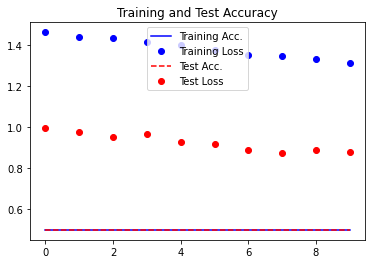

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Get the classification accuracy and loss-value
    # for the training-set.
    acc = history.history['accuracy']
    loss = history.history['loss']

    # Get it for the validation-set (we only use the test-set).
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    # Plot the accuracy and loss-values for the training-set.
    plt.plot(acc, linestyle='-', color='b', label='Training Acc.')
    plt.plot(loss, 'o', color='b', label='Training Loss')
    
    # Plot it for the test-set.
    plt.plot(val_acc, linestyle='--', color='r', label='Test Acc.')
    plt.plot(val_loss, 'o', color='r', label='Test Loss')

    # Plot title and legend.
    plt.title('Training and Test Accuracy')
    plt.legend()

    # Ensure the plot shows correctly.
    plt.show()
plot_training_history(history)

In [ ]:
!zip checkpoints_04.zip checkpoints_04

  adding: checkpoints_04/ (stored 0%)


In [ ]:
!rm -rf checkpoints_04

In [ ]:
!cp checkpoints_04.zip /content/drive/MyDrive/FaceMaskDetection/

In [ ]:
import zipfile

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def zipdir(path, ziph):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file))

def upload_model(log_dir,model_name):
  folderName = 'FaceMaskDetection'  
  folders = drive.ListFile(
      {'q': "title='" + folderName + "' and mimeType='application/vnd.google-apps.folder' and trashed=false"}).GetList()



  zipf = zipfile.ZipFile('checkpoints_'+model_name+'_weights_best'+'.zip', 'w', zipfile.ZIP_DEFLATED)
  zipdir('checkpoints_'+model_name, zipf)
  zipf.close()

  for folder in folders:
      if folder['title'] == folderName:        
          file1 = drive.CreateFile({"parents": [{"kind": "drive#fileLink", "id": folder['id']}]})
          file1.SetContentFile('checkpoints_'+model_name+'_weights_best.zip')
          file1.Upload()
          print('Uploaded file {} with ID {}'.format(file1.get('title'),file1.get('id')))

  # !cp -R log_dir_vgg19 /content/drive/My\ Drive/ModelsWeights/FaceMaskDetection/
  # !zip -q -r log_dir.zip log_dir
  

  # zipf = zipfile.ZipFile(model_name+'_best_model'+'.zip', 'w', zipfile.ZIP_DEFLATED)
  # zipdir(model_name+'_best_model', zipf)
  # zipf.close()

  # for folder in folders:
  #     if folder['title'] == folderName:        
  #         file1 = drive.CreateFile({"parents": [{"kind": "drive#fileLink", "id": folder['id']}]})
  #         file1.SetContentFile(model_name+'_best_model.zip')
  #         file1.Upload()
  #         print('Uploaded file with ID {}'.format(file1.get('id')))

  zipf = zipfile.ZipFile(log_dir+'.zip', 'w', zipfile.ZIP_DEFLATED)
  zipdir(log_dir, zipf)
  zipf.close()

  for folder in folders:
      if folder['title'] == folderName:        
          file1 = drive.CreateFile({"parents": [{"kind": "drive#fileLink", "id": folder['id']}]})
          file1.SetContentFile(log_dir+'.zip')
          file1.Upload()
          print('Uploaded file {} with ID {}'.format(file1.get('title'),file1.get('id')))

upload_model('log_dir-04','04')

Uploaded file checkpoints_04_weights_best1.zip with ID 1oqH7CQ_wZz4EPhbfSLV9CLMqsivBpbcc


#evaluate model

In [ ]:
!ls -l checkpoints_04

total 58356
-rw-r--r-- 1 root root      105 Aug 25 00:31 checkpoint
-rw-r--r-- 1 root root 59747950 Aug 25 00:31 facemask_04_weights_best.data-00000-of-00001
-rw-r--r-- 1 root root     2384 Aug 25 00:31 facemask_04_weights_best.index


In [ ]:
model04=model
model04.compile(optimizer=optimizers.Adam(lr=1e-04),
                 loss='binary_crossentropy',metrics=['accuracy'])
model04.load_weights('checkpoints_04/facemask_04_weights_best')

In [ ]:
# model.load_weights('05__best_model.keras')
# m=load_model("facemask_05_weights_best")

In [ ]:
time1 = datetime.datetime.now()
test_loss, test_acc = model04.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size)
time2 = datetime.datetime.now()
print('finished in        {}\n'.format(time2-time1))
print('test acc:', test_acc)
print('test loss:', test_loss)

461/460 [==============================] - 58s 126ms/step - loss: 0.0838 - accuracy: 0.9987
finished in        0:01:06.205144

test acc: 0.9987114071846008
test loss: 0.08383702486753464


In [ ]:
!nvidia-smi

Thu Dec 17 09:23:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    44W / 250W |   9001MiB / 16280MiB |     58%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
from keras.preprocessing.image import load_img
# Create a generator for prediction

# test_generator = test_datagen.flow_from_directory(
#         test_dir,
#         target_size=(image_size, image_size),
#         batch_size=128,
#         class_mode='categorical',
#         shuffle=False)

# Get the filenames from the generator
fnames = test_generator.filenames
 
# Get the ground truth from generator
ground_truth = test_generator.classes
 
# Get the label to class mapping from the generator
label2index = test_generator.class_indices
 
# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())
 
# Get the predictions from the model using the generator
#model.load_weights('pretrained.weights.best.hdf5')

predictions = model.predict(test_generator, steps=test_generator.samples/test_generator.batch_size,verbose=1)

predicted_classes = np.round(predictions)
     
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')

print(confusion_matrix(test_generator.classes,predicted_classes))

print('Classification Report')

target_names = ['class_1', 'class_2']
print('       ')
print(classification_report(test_generator.classes,predicted_classes , target_names=target_names))

461/460 [==============================] - 110s 239ms/step
Confusion Matrix
[[14690    55]
 [   11 14734]]
Classification Report
       
              precision    recall  f1-score   support

     class_1       1.00      1.00      1.00     14745
     class_2       1.00      1.00      1.00     14745

    accuracy                           1.00     29490
   macro avg       1.00      1.00      1.00     29490
weighted avg       1.00      1.00      1.00     29490



In [ ]:
# TP = 14690
# FN = 11
# TN = 14734
# FP = 55
# precision = TP / TP+FP
# precision = 14690/14690+55 = 0.996269922
# recall = TP / TP+FN
# recall = 14690/14690+11 = 0.999251752

In [ ]:
import glob
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import imageio as im
from keras.preprocessing import image


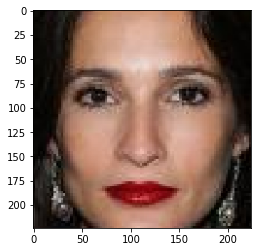

(1, 224, 224, 3)


In [ ]:
img_path = "RMFD/test/without_mask/106.png"

imae = image.load_img(img_path, target_size=(224, 224))
igm_arr = image.img_to_array(imae)
igm_arr = np.expand_dims(igm_arr, axis=0)
igm_arr /= 255.
plt.imshow(igm_arr[0])
plt.show()

print(igm_arr.shape)

In [ ]:
layer_outputs = [layer.output for layer in model.layers] 
activation_model = Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

In [ ]:
activations = activation_model.predict(igm_arr)


In [ ]:
len(activations)

24

In [ ]:
print(activations[22].shape)
print(activations[22].reshape(activations[22].shape[1],-1).shape)
print(tf.squeeze(activations[22]).shape)

(1, 1, 16)
(1, 16)
(16,)


In [ ]:
activations[22]

array([[[-0.01643737, -0.26996854,  0.09552682, -0.1856645 ,
          0.04407956, -0.26616848,  0.14933595, -0.36244708,
         -0.01401331,  0.23860525,  0.2695128 , -0.14590631,
          0.19327469,  0.3725812 ,  0.2656564 ,  0.25474304]]],
      dtype=float32)

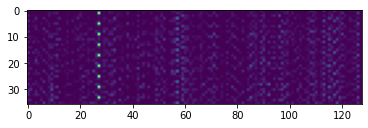

In [ ]:
plt.imshow( tf.squeeze(activations[21]) )
# plt.imshow( activations[22].reshape(activations[22].shape[1], -1) )
plt.show()

In [ ]:
from keras.models import Model
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(igm_arr)
 
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0,  :, activation_index], cmap='gray')
            activation_index += 1
 

In [ ]:
#igm_arr
display_activation(activations, 8, 8, 21)

In [ ]:
layer_names = []
for layer in model.layers:
    layer_names.append(layer.name)
activations = activation_model.predict(igm_arr)

layer_names

layer_name  block1_conv1
layer_name  block1_conv2
layer_name  block1_pool
layer_name  block2_conv1
layer_name  block2_conv2
layer_name  block2_pool


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


layer_name  block3_conv1
layer_name  block3_conv2
layer_name  block3_conv3
layer_name  block3_pool
layer_name  block4_conv1
layer_name  block4_conv2
layer_name  block4_conv3
layer_name  block4_pool
layer_name  block5_conv1
layer_name  block5_conv2
layer_name  block5_conv3
layer_name  block5_pool
layer_name  max_pooling2d_3


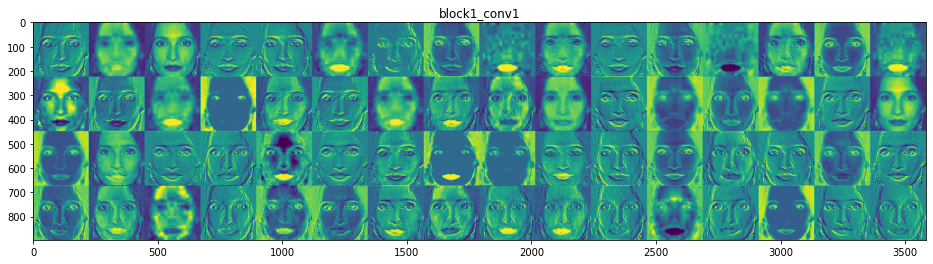

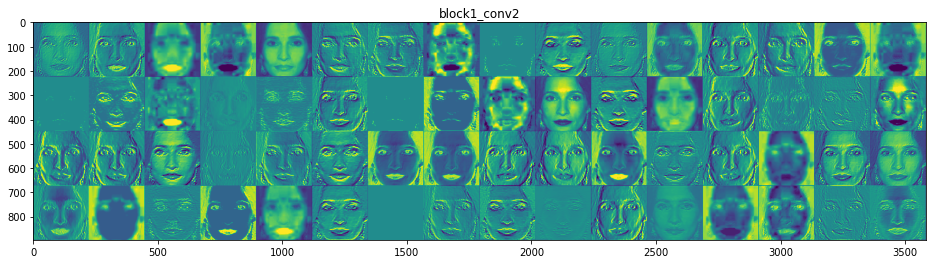

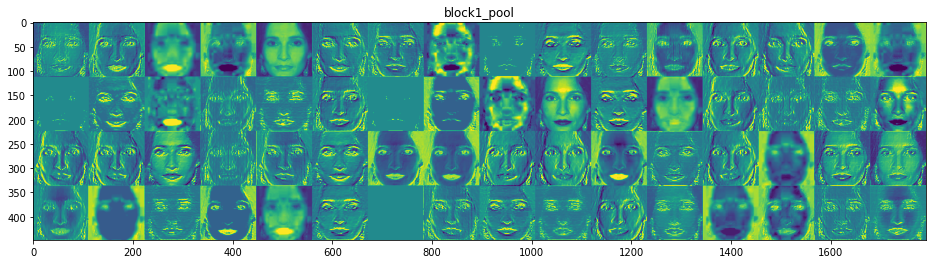

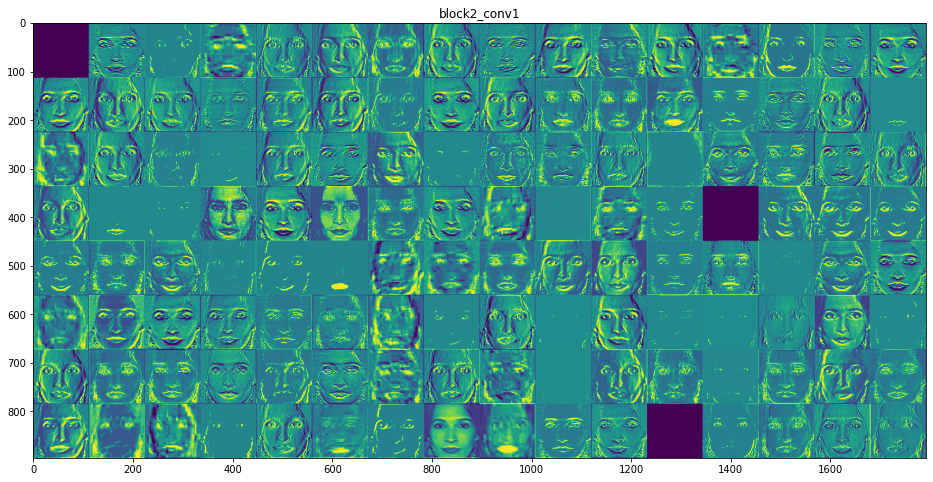

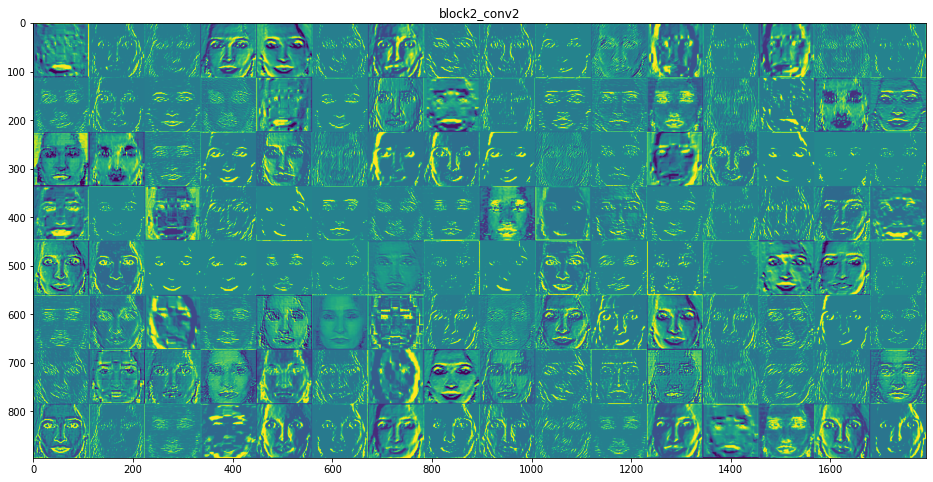

In [ ]:
layer_names = layer_names[1:20]
activations = activations[1:20]
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    # print('layer_name ',layer_name)
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')